# Download and install libraries

In [2]:
! pip install pytorch-lightning

In [5]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import os
import random

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import ConcatDataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initialization

Data

In [9]:
columns_to_read = ['1 LDF', '1 T', 'Sleep stages']
#columns_to_read = ['1 LDF', 'Sleep stages']
columns_dtype = {
    columns_to_read[0]:  'float32',
    columns_to_read[1]:  'float32',
    columns_to_read[-1]: 'int16',

 }

t_lower_bound = 35
big_file_no = 3
L_lower_threshold = 0
L_upper_threshold = 60
t_lower_threshold = 34

# Dictionary to map strings to integers
replacement_dict = {
    'W' : 0,
    'N2': 1,
    'N3': 1,
    'R' : 1
}

fragment_length = 400
num_samples = 4000
batch_size = 100
num_folds = 6

Model

In [12]:
num_features = len(columns_to_read) - 1
num_classes = 2

# Initialize the model
input_size = fragment_length * num_features  # Assuming 2 features per fragment
hidden_size = 50

lr = 0.005
n_epochs = 100

# Supplementary functions

Pre-processing of table data

In [16]:
def df_clean(df, columns_to_read=columns_to_read, replacement_dict=replacement_dict):
  # delete rows with nan values in a column
  df = df.dropna()
  # LDF
  df = df[df[columns_to_read[0]] > L_lower_threshold]
  df = df[df[columns_to_read[0]] < L_upper_threshold]
  # Temperature
  df = df[df[columns_to_read[1]] > t_lower_threshold]
  # the last column is for labels
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
  return df

def change_dtypes(df, columns_dtype):
  df = df.astype(columns_dtype)
  return df

In [18]:
def plot_batch_features(features, targets, batch_idx):
    """
    Plots the features of a batch and uses the labels as captions.

    Args:
        features (torch.Tensor): The features tensor of shape (batch_size, num_features).
        targets (torch.Tensor): The targets tensor of shape (batch_size,).
        batch_idx (int): The index of the batch.
    """
    batch_size = features.shape[0]
    num_features = features.shape[1]

    fig, axes = plt.subplots(1, batch_size, figsize=(3 * batch_size, 3))

    if batch_size == 1:
        axes = [axes]  # Ensure axes is a list if batch_size is 1

    for i in range(batch_size):
        ax = axes[i]
        ax.plot(features[i].cpu().numpy())
        ax.set_title(f'Batch {batch_idx + 1}, Sample {i + 1}, Label: {targets[i].item()}')
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Feature Value')

    plt.tight_layout()
    plt.show()

In [20]:
def vis_data(df, columns_to_read=columns_to_read):
    # Создаем фигуру с подграфиками
    num_columns = len(columns_to_read)
    fig, axes = plt.subplots(1, num_columns * 2, figsize=(15, 3))

    # Итерация по колонкам для визуализации
    for k, column in enumerate(columns_to_read):
        # Гистограмма с KDE
        sns.histplot(df[column], kde=True, ax=axes[k * 2])
        axes[k * 2].set_title(f'Distribution of {column}')
        axes[k * 2].set_xlabel(column)
        axes[k * 2].set_ylabel('Frequency')

        # Диаграмма рассеяния
        sns.scatterplot(x=df.index, y=df[column], ax=axes[k * 2 + 1])
        axes[k * 2 + 1].set_title(f'Values of {column}')
        axes[k * 2 + 1].set_xlabel('Sample ID')
        axes[k * 2 + 1].set_ylabel(column)

    # Настройка макета и отображение графиков
    plt.tight_layout()
    plt.show()

# Download data

In [23]:
# GitHub repository URL
repo_url = "https://github.com/kotosham/sleep-stages"

# Raw files URLs
download_files = ['1.csv', '2.csv', '3-1.csv', '3-2.csv',
                  '4.csv', '5.csv', '6.csv', '7.csv']
# files_with_subfiles = ['3']

for i in download_files:
  file_url = f"{repo_url}/raw/main/{i}"
  # Download the file
  response = requests.get(file_url)
  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file
      with open(i, "wb") as file:
          file.write(response.content)
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Concatinate parts of a big file

In [25]:
dfs = []
df_3_1 = pd.read_csv('3-1.csv', usecols=columns_to_read)
dfs.append(df_3_1)
df_3_2 = pd.read_csv('3-2.csv', usecols=columns_to_read)
dfs.append(df_3_2)
df3 = pd.concat(dfs, ignore_index=True)
df3 = df_clean(df3)
df3 = change_dtypes(df3, columns_dtype)
print(df3.head())

    1 LDF    1 T  Sleep stages
12   14.3  34.57             0
13   14.3  34.57             0
14   14.3  34.57             0
15   14.3  34.57             0
16   17.1  34.57             0


C:\Users\user\AppData\Local\Temp\ipykernel_3016\1225262908.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Collect all the files into a list of data frames

In [29]:
num_volunteers = (len(download_files) - 1)
files = [1]*num_volunteers
for i in range(num_volunteers):
  if i + 1 != big_file_no:
    print(i)
    f"{repo_url}/raw/main/{i}"
    files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
    files[i] = df_clean(files[i])
    files[i] = change_dtypes(files[i], columns_dtype)
files[big_file_no - 1] = df3

0


C:\Users\user\AppData\Local\Temp\ipykernel_3016\1225262908.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
C:\Users\user\AppData\Local\Temp\ipykernel_3016\1225262908.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


1
3


C:\Users\user\AppData\Local\Temp\ipykernel_3016\1225262908.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


4


C:\Users\user\AppData\Local\Temp\ipykernel_3016\1225262908.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


5


C:\Users\user\AppData\Local\Temp\ipykernel_3016\1225262908.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


6


C:\Users\user\AppData\Local\Temp\ipykernel_3016\596437969.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
C:\Users\user\AppData\Local\Temp\ipykernel_3016\1225262908.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Means and variances

In [32]:
alldf = pd.concat(files, axis=0)
features = alldf[columns_to_read[:-1]].values
means = features.mean(axis=0)
stds = features.std(axis=0)
del[alldf, features]
means, stds

(array([24.322649, 37.519753], dtype=float32),
 array([4.7911134, 0.5178968], dtype=float32))

Visualize all the files

Volunteer 1
Number of samples 166627


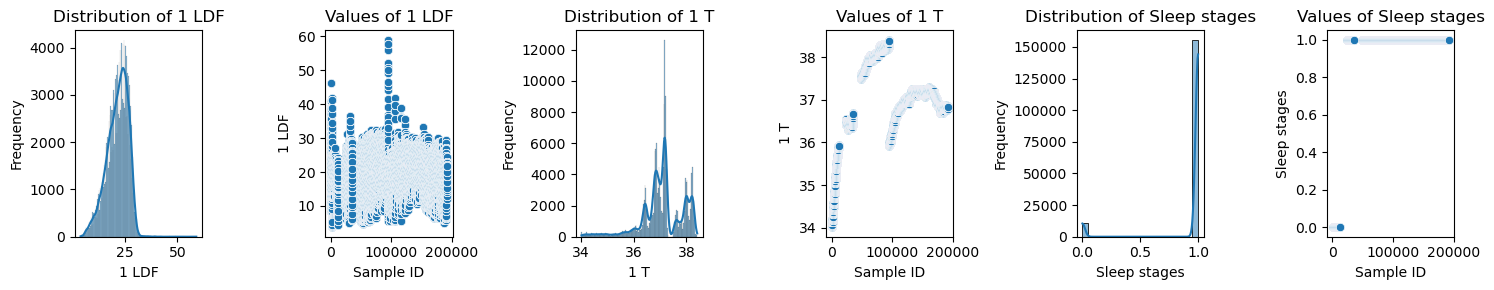

Volunteer 2
Number of samples 112848


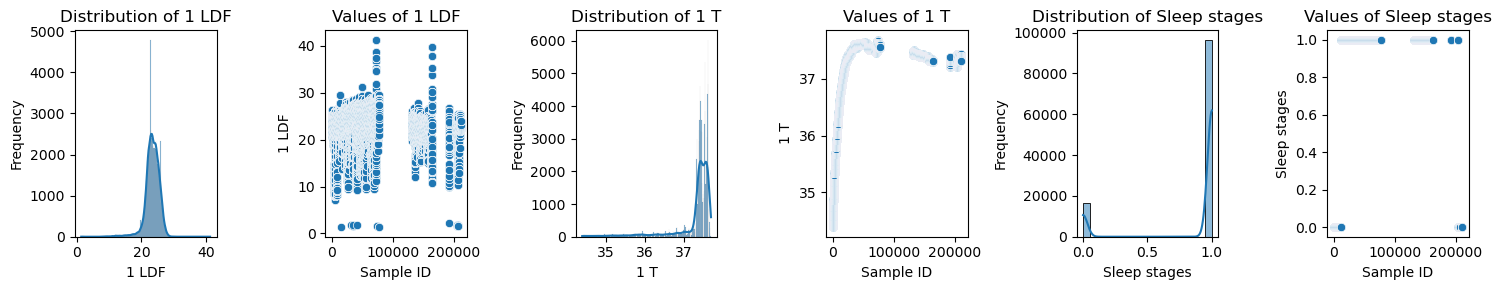

Volunteer 3
Number of samples 411736


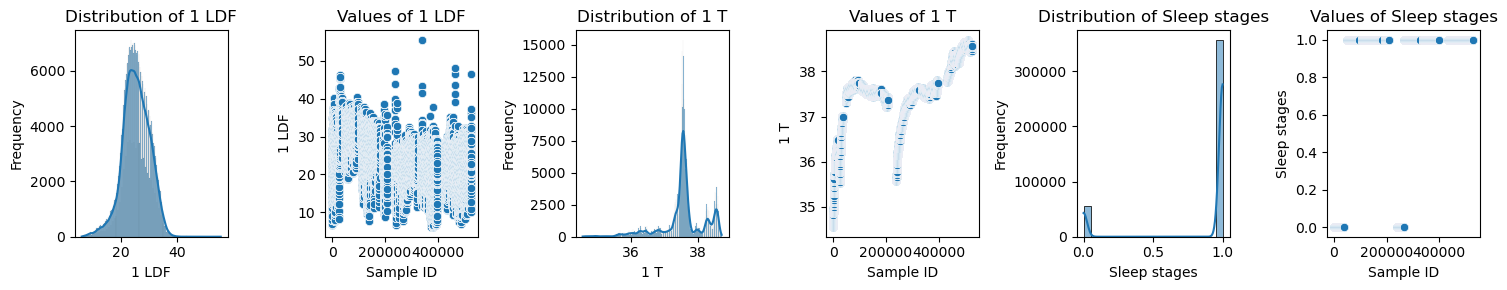

Volunteer 4
Number of samples 101844


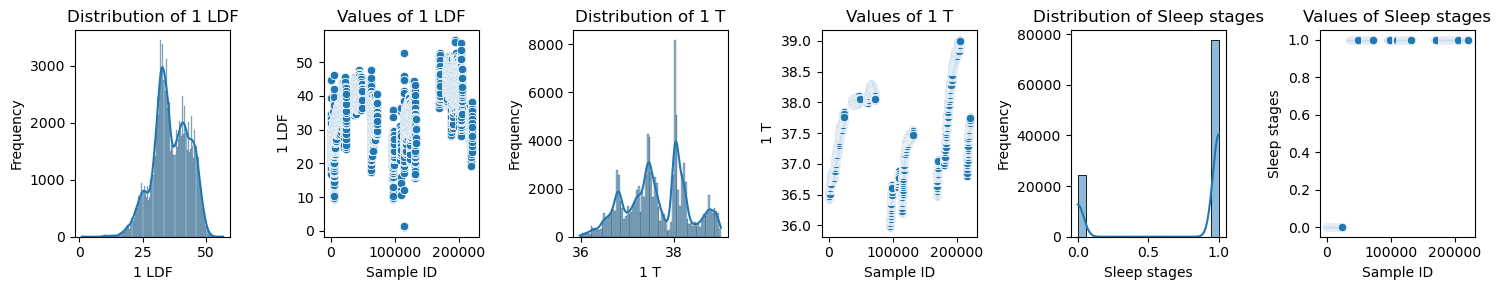

Volunteer 5
Number of samples 366509


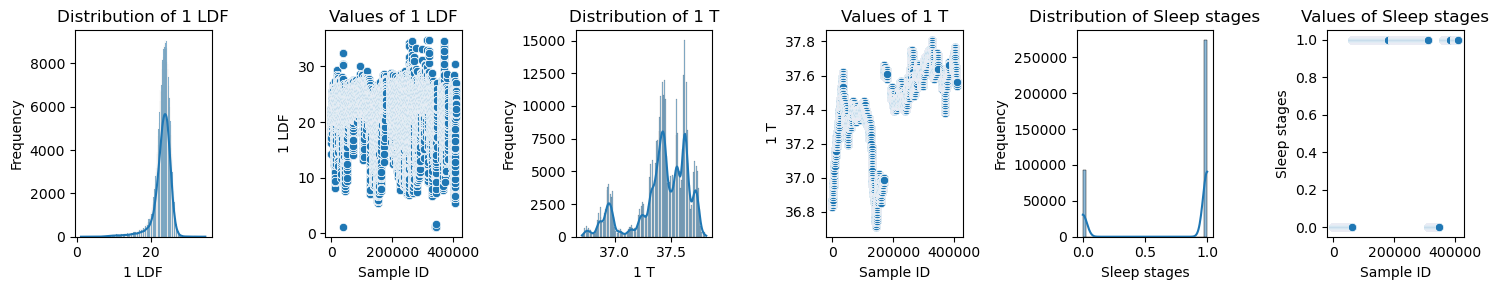

Volunteer 6
Number of samples 390907


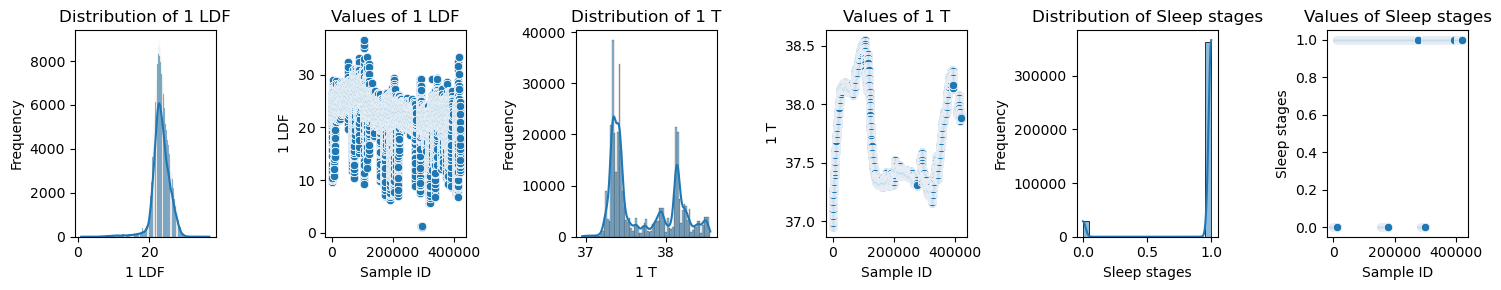

Volunteer 7
Number of samples 390757


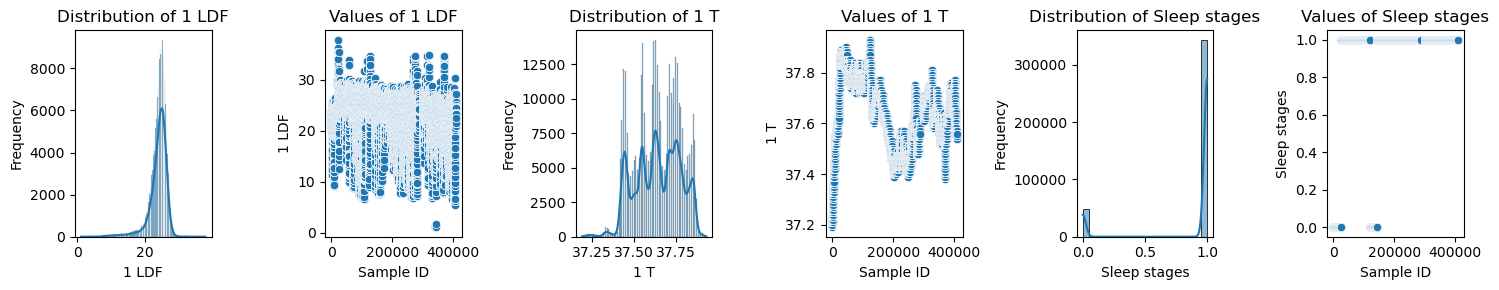

In [35]:
for i in range(num_volunteers):
  print(f'Volunteer {i+1}')
  print(f'Number of samples {len(files[i])}')
  vis_data(files[i])

In [36]:
files[1]

,1 LDF,1 T,Sleep stages
3,24.5,34.389999,0
4,24.5,34.389999,0
5,24.5,34.389999,0
6,24.5,34.389999,0
7,24.5,34.389999,0
...,...,...,...
211019,24.0,37.340000,0
211020,24.0,37.340000,0
211021,23.9,37.320000,0
211022,23.9,37.320000,0


# Dataset, dataloader, model, and training procedure

In [40]:
# Определение класса FragmentDataset
class FragmentDataset(Dataset):
    def __init__(self, dataframe, fragment_length, num_samples):
        self.dataframe = dataframe
        self.fragment_length = fragment_length
        self.num_samples = num_samples
        self.data = self.load_data()

    def load_data(self):
        data = []
        class_column = self.dataframe.columns[-1]
        unique_classes = self.dataframe[class_column].unique()

        for _ in range(self.num_samples):
            selected_class = random.choice(unique_classes)
            class_data = self.dataframe[self.dataframe[class_column] == selected_class]
            if len(class_data) < self.fragment_length:
                continue  # Пропускаем, если недостаточно данных для фрагмента

            start_idx = random.randint(0, len(class_data) - self.fragment_length)
            fragment = class_data.iloc[start_idx:start_idx + self.fragment_length].values
            fragment = torch.tensor(fragment[:, :-1], dtype=torch.float32)  # Признаки
            label = torch.tensor(int(selected_class), dtype=torch.long)  # Метка
            fragment = fragment.flatten()
            data.append((fragment, label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fragment, label = self.data[idx]
        return fragment, label


# Определение класса FragmentDataModule
class FragmentDataModule(pl.LightningDataModule):
    def __init__(self, files, fragment_length=400, num_samples=4000, batch_size=100, num_folds=6):
        self.files = files
        self.fragment_length = fragment_length
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.num_folds = num_folds

    def setup(self, stage=None):
        # Загрузка данных из файлов и создание наборов данных
        self.datasets = [FragmentDataset(df, self.fragment_length, self.num_samples) for df in self.files]
        self.kfold = KFold(n_splits=self.num_folds)

    def train_dataloader(self, train_indices):
        train_datasets = [self.datasets[i] for i in train_indices]
        return DataLoader(torch.utils.data.ConcatDataset(train_datasets), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self, val_indices):
        # val_indices теперь должен быть массивом индексов
        val_datasets = [self.datasets[i] for i in val_indices]
        return DataLoader(torch.utils.data.ConcatDataset(val_datasets), batch_size=self.batch_size)

    def test_dataloader(self, test_index):
        test_dataset = self.datasets[test_index]
        return DataLoader(test_dataset, batch_size=self.batch_size)


# Определение модели MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# Определение класса MLPModel для PyTorch Lightning
class MLPModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)

        preds = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y.cpu(), preds.cpu())

        # Логирование потерь и точности
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)

        preds = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y.cpu(), preds.cpu())

        # Логирование потерь и точности валидации
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)

        # Логирование потерь тестирования
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

### MLP model

In [27]:
data_module = FragmentDataModule(files)
data_module.setup()

# Выполнение кросс-валидации и обучение модели на каждом фолде
for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(data_module.datasets)):
    print(f'Fold {fold + 1}')

    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    # Инициализация модели MLP для текущего фолда
    model_input_size = 400 * 2  # Длина фрагмента * количество признаков (2 признака)
    model = MLPModel(input_size=model_input_size, hidden_size=50, num_classes=2)

    # Инициализация тренера PyTorch Lightning
    trainer = pl.Trainer(max_epochs=100)

    # Обучение модели на текущем фолде
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Получение результатов валидации
    val_acc = trainer.callback_metrics['val_acc'].item()  # Получаем значение точности валидации
    print(f'Accuracy for Fold {fold + 1}: {val_acc:.4f}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fold 1


C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Accuracy for Fold 1: 0.4931
Fold 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Accuracy for Fold 2: 0.4963
Fold 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Accuracy for Fold 3: 0.5105
Fold 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Accuracy for Fold 4: 0.4980
Fold 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Accuracy for Fold 5: 0.4940
Fold 6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Accuracy for Fold 6: 0.4920


In [28]:
# После завершения кросс-валидации вы можете протестировать модель на тестовых данных.
# Предположим, что последний файл в списке - это тестовый набор (например, files[6]).

test_index = 6  # Индекс тестового набора
test_loader = data_module.test_dataloader(test_index)

# Инициализация модели MLP для тестирования
model_input_size = 400 * 2  # Длина фрагмента * количество признаков (2 признака)
test_model = MLPModel(input_size=model_input_size, hidden_size=50, num_classes=2)

# Загрузка лучших весов модели (выберите модель с лучшей валидационной точностью)
best_model_path = trainer.checkpoint_callback.best_model_path
test_model = MLPModel.load_from_checkpoint(best_model_path,
                                            input_size=model_input_size,
                                            hidden_size=50,
                                            num_classes=2)

# Тестирование модели
test_results = trainer.test(model=test_model, dataloaders=test_loader)

# Вычисление точности для тестового набора
y_true = []
y_pred = []

for batch in test_loader:
    x, y = batch
    outputs = test_model(x)
    preds = torch.argmax(outputs, dim=1)
    y_true.extend(y.tolist())
    y_pred.extend(preds.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.691987156867981     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 0.4920


### Decision Tree Model

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
data_module = FragmentDataModule(files)
data_module.setup()

Fold 1


ValueError: too many values to unpack (expected 2)

In [93]:
for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(data_module.datasets)):
    print(f'Fold {fold + 1}')
    
    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    # Подготовка данных для дерева решений
    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch  # Распаковка кортежа
        X_train.append(features.numpy())  # Признаки

        # Убедитесь, что метки имеют правильную форму
        y_train.append(labels.numpy())  # Метки

    # Преобразуем списки в двумерные массивы
    X_train = np.vstack(X_train)  # Используем vstack для создания двумерного массива
    y_train = np.concatenate(y_train)  # Объединяем метки в одномерный массив

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch  # Распаковка кортежа
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    # Преобразуем списки в двумерные массивы
    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    # Инициализация и обучение модели дерева решений с настройкой гиперпараметров
    model_dt = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        criterion='gini'
    )
    
    model_dt.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_dt.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)
    
    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.7594
Fold 2
Validation Accuracy for Fold 2: 0.6545
Fold 3
Validation Accuracy for Fold 3: 0.5330
Fold 4
Validation Accuracy for Fold 4: 0.5080
Fold 5
Validation Accuracy for Fold 5: 0.4853
Fold 6
Validation Accuracy for Fold 6: 0.4715


In [95]:
# После завершения кросс-валидации вы можете протестировать модель на тестовых данных.
test_index = 6  # Индекс тестового набора (например files[6])
test_loader = data_module.test_dataloader(test_index)

# Подготовка тестовых данных для дерева решений
X_test, y_test = [], []
for batch in test_loader:
    features, labels = batch  # Распаковка кортежа
    X_test.append(features.numpy())  # Признаки

    # Убедитесь, что метки имеют правильную форму
    y_test.append(labels.numpy())  # Метки

# Преобразуем списки в двумерные массивы
X_test = np.vstack(X_test)  # Используем vstack для создания двумерного массива
y_test = np.concatenate(y_test)  # Объединяем метки в одномерный массив

# Тестирование модели на тестовом наборе
test_preds = model_dt.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.4715


### SVC model

In [68]:
from sklearn.svm import SVC

In [70]:
for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(data_module.datasets)):
    print(f'Fold {fold + 1}')
    
    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    # Подготовка данных для SVM
    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch  # Распаковка кортежа
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)  # Объединяем в двумерный массив
    y_train = np.concatenate(y_train)  # Объединяем метки в одномерный массив

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch  # Распаковка кортежа
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)  # Объединяем в двумерный массив
    y_val = np.concatenate(y_val)  # Объединяем метки в одномерный массив

    # Инициализация и обучение модели SVM с настройкой гиперпараметров
    model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')  # Пример гиперпараметров
    
    model_svm.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)
    
    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.7246
Fold 2
Validation Accuracy for Fold 2: 0.9055
Fold 3
Validation Accuracy for Fold 3: 0.7755
Fold 4
Validation Accuracy for Fold 4: 0.5165
Fold 5
Validation Accuracy for Fold 5: 0.5178
Fold 6
Validation Accuracy for Fold 6: 0.4950


In [74]:
# После завершения кросс-валидации вы можете протестировать модель на тестовых данных.
test_index = 3
test_loader = data_module.test_dataloader(test_index)

# Подготовка тестовых данных для SVM
X_test, y_test = [], []
for batch in test_loader:
    features, labels = batch  # Распаковка кортежа
    X_test.append(features.numpy())  # Признаки
    y_test.append(labels.numpy())     # Метки

X_test = np.vstack(X_test)  # Объединяем в двумерный массив
y_test = np.concatenate(y_test)  # Объединяем метки в одномерный массив

# Тестирование модели на тестовом наборе
test_preds = model_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8393
